# DAS Data Compression using Autoencoder

This notebook shows how to do lossy DAS data compression using neural networks (Autoencoder). The original code is from [TensorFlow Compression](https://github.com/tensorflow/compression).

## Paper and posts for understanding related theories

1. [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)
2. [Image Compression Using Autoencoders in Keras](https://blog.paperspace.com/autoencoder-image-compression-keras/)
3. [AI-Based Image Compression: The State of the Art](https://towardsdatascience.com/ai-based-image-compression-the-state-of-the-art-fb5aa6042bfa)

Import library dependencies.

In [4]:
import glob
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import sys
sys.path.append('../models/')
from model import train_das_model, make_das_codec
from utils import extract_image_patches_fast, prepare_das_dataset, reconstruct_image_from_patches, load_patch_from_file
from utils import norm_channel

plt.rcParams.update({'font.size': 14})

## Load the preprocessed DAS data from the Google Storate

In [3]:
# Set the data for trainning
file_train = sorted(glob.glob('../data/train/*.npz'))
file_test = sorted(glob.glob('../data/test/*.npz'))


file_path = '../data/original_data/'
file_train = [file_path + 'smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz', \
              file_path + 'smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-26_T00-37-56_p10min.npz', \
              file_path + 'smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz']

file_test = [file_path + 'smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-26_T00-37-56_p10min.npz']



# print("\n--------------Trainning Dataset--------------\n")
# print(file_train)

# print("\n--------------Test Dataset--------------\n")
# print(file_test)

../data/original_data/smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz     Data shape:  (3100, 3000)
../data/original_data/smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-26_T00-37-56_p10min.npz     Data shape:  (3100, 3000)
../data/original_data/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz     Data shape:  (4800, 3000)


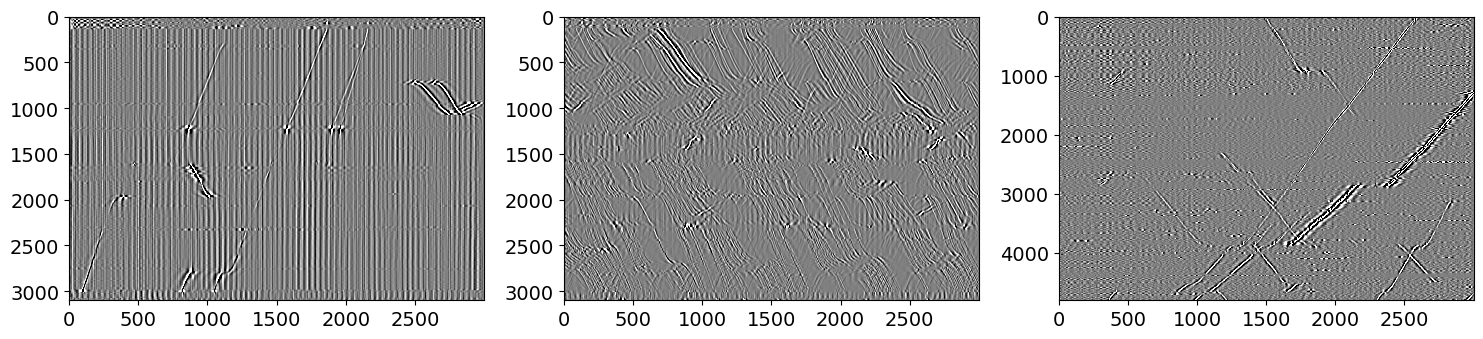

In [7]:
# Plot all trainning DAS data
plt.figure(figsize=(20, 20))
for i, file in enumerate(file_train):
  # Load the data and print basic retrieved parameters
  pdata = norm_channel(np.load(file)['pdata'])

  print(file, '    Data shape: ', pdata.shape)

  # Plot 
  plt.subplot(6, 4, i+1)
  pclip = np.percentile(pdata, 97.)
  plt.imshow(pdata, cmap='gray', aspect='auto', vmin=-pclip, vmax=pclip)

plt.tight_layout()
plt.show()

In [8]:
# Setup parameters for generating patches
patch_size = 32          # size of each patch
train_ratio = 0.8        # ratio between training and dev 
shuffle = True           # shuffle all patches or not
overlap = False          # overlap or not when retriving patches, i.e., tile for half patch_size
add_noise = True         # add random noise to each patch or not
snr = 150                # value for signal-to-noise ratio

# Setup parameters for training model
lmbda = 2000         # weight for rate–distortion Lagrangian
latent_dims = 100    # layers in latent space
epochs = 50          # epoch
batch_size = 128     # batch size
learning_rate = 1e-3 # learning rate
validation_freq = 1  # validation frequency

In [9]:
# Retrive patches from save files
input_patches, ouput_patches, factors = load_patch_from_file(file_train, 
                                                             patch_size, 
                                                             overlap = overlap, 
                                                             add_noise = add_noise, 
                                                             snr = snr)


Loading: ../data/original_data/smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz
Loading: ../data/original_data/smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-26_T00-37-56_p10min.npz
Loading: ../data/original_data/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz
Number of patches in total:  31713


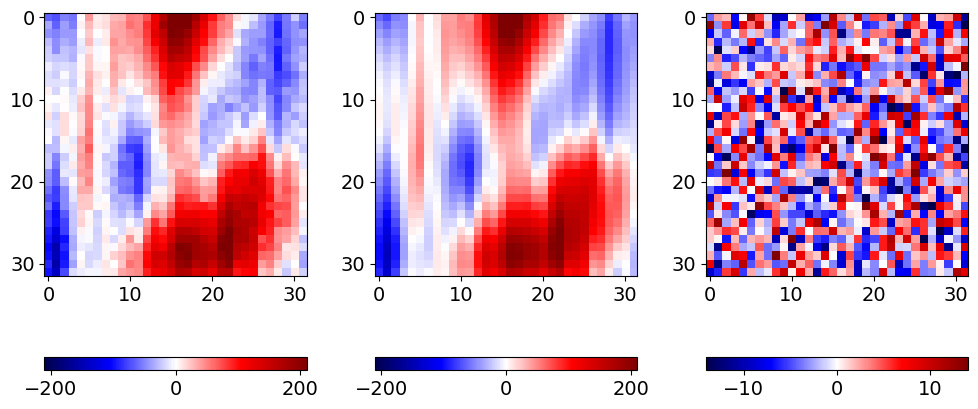

In [10]:
# check the input
idx = 200
plt.figure(figsize=(10, 5))
for i,data in enumerate([input_patches[idx], 
                         ouput_patches[idx], 
                         input_patches[idx] - ouput_patches[idx]]):
  
  pclip = np.percentile(data, 99.)
  plt.subplot(1,3,i+1)
  plt.imshow(data, cmap='seismic', vmin=-pclip, vmax=pclip)
  plt.colorbar(orientation="horizontal",fraction=0.07,anchor=(1.0,0.0))
  
plt.tight_layout()

In [11]:
# Prepare the training and dev dataset into tensorflow
train_dataset, dev_dataset = prepare_das_dataset(input_patches, 
                                                 ouput_patches, 
                                                 train_ratio = train_ratio, 
                                                 shuffle = shuffle)

2023-05-31 14:40:06.925192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30937 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-05-31 14:40:06.926777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30937 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5e:00.0, compute capability: 7.0
2023-05-31 14:40:06.928445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 30937 MB memory:  -> device: 2, name: Tesla V100-PCIE-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0
2023-05-31 14:40:06.929900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 30937 MB memory:  -> device: 3, name: Tesla V100-PCIE-32GB, pci bus id



Number of train data:  25370
Number of valid data:  6343
<_ZipDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float64, name=None), TensorSpec(shape=(32, 32, 1), dtype=tf.float64, name=None))>
<_ZipDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float64, name=None), TensorSpec(shape=(32, 32, 1), dtype=tf.float64, name=None))>


## Train the model

In [12]:
trainer, history = train_das_model(
                    train_dataset,                         # training dataset
                    dev_dataset,                           # dev dataset
                    lmbda=lmbda,                           # weight for rate–distortion Lagrangian
                    latent_dims=latent_dims,               # layers in latent space
                    patch_size = patch_size,               # patch size of the image, must be dividable by 4
                    epochs=epochs,                         # epoch
                    batch_size=batch_size,                 # batch size
                    learning_rate=learning_rate,           # learning rate
                    validation_freq=validation_freq,       # validation frequency
                    launch_trainer = True)                 # launch the trainer
                    

Epoch 1/50


2023-05-31 14:41:15.550001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [25370,32,32]
	 [[{{node Placeholder/_3}}]]
2023-05-31 14:41:19.559859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-31 14:41:20.925441: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x60aeedd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-31 14:41:20.925533: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-05-31 14:41:20.925564: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-05-31 14:41:20.925592: I tensorfl

199/199 [==============================] - ETA: 0s - loss: 522.6306 - distortion_loss: 0.1569 - rate_loss: 208.7911 - distortion_pass_through_loss: 0.1567 - rate_pass_through_loss: 208.7690

2023-05-31 14:41:27.956714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [6343,32,32]
	 [[{{node Placeholder/_3}}]]


199/199 [==============================] - 13s 26ms/step - loss: 522.6306 - distortion_loss: 0.1569 - rate_loss: 208.7911 - distortion_pass_through_loss: 0.1567 - rate_pass_through_loss: 208.7690 - val_loss: 436.8770 - val_distortion_loss: 0.1162 - val_rate_loss: 204.3813 - val_distortion_pass_through_loss: 0.1162 - val_rate_pass_through_loss: 204.3774
Epoch 2/50
199/199 [==============================] - 4s 20ms/step - loss: 418.6464 - distortion_loss: 0.1108 - rate_loss: 197.0189 - distortion_pass_through_loss: 0.1108 - rate_pass_through_loss: 196.9853 - val_loss: 405.8500 - val_distortion_loss: 0.1076 - val_rate_loss: 190.7325 - val_distortion_pass_through_loss: 0.1075 - val_rate_pass_through_loss: 190.7287
Epoch 3/50
199/199 [==============================] - 4s 20ms/step - loss: 391.0379 - distortion_loss: 0.1041 - rate_loss: 182.7528 - distortion_pass_through_loss: 0.1041 - rate_pass_through_loss: 182.7150 - val_loss: 383.1250 - val_distortion_loss: 0.1034 - val_rate_loss: 176.26

199/199 [==============================] - 4s 20ms/step - loss: 274.4125 - distortion_loss: 0.0907 - rate_loss: 92.9960 - distortion_pass_through_loss: 0.0907 - rate_pass_through_loss: 92.9841 - val_loss: 267.0332 - val_distortion_loss: 0.0944 - val_rate_loss: 78.2764 - val_distortion_pass_through_loss: 0.0944 - val_rate_pass_through_loss: 78.2724
Epoch 24/50
199/199 [==============================] - 4s 20ms/step - loss: 273.5396 - distortion_loss: 0.0906 - rate_loss: 92.3126 - distortion_pass_through_loss: 0.0906 - rate_pass_through_loss: 92.3036 - val_loss: 266.6701 - val_distortion_loss: 0.0940 - val_rate_loss: 78.7448 - val_distortion_pass_through_loss: 0.0940 - val_rate_pass_through_loss: 78.7398
Epoch 25/50
199/199 [==============================] - 4s 20ms/step - loss: 272.6372 - distortion_loss: 0.0906 - rate_loss: 91.5359 - distortion_pass_through_loss: 0.0905 - rate_pass_through_loss: 91.5196 - val_loss: 266.2452 - val_distortion_loss: 0.0940 - val_rate_loss: 78.1695 - val_d

Epoch 46/50
199/199 [==============================] - 4s 20ms/step - loss: 262.5907 - distortion_loss: 0.0878 - rate_loss: 86.9907 - distortion_pass_through_loss: 0.0878 - rate_pass_through_loss: 86.9905 - val_loss: 263.6529 - val_distortion_loss: 0.0911 - val_rate_loss: 81.4970 - val_distortion_pass_through_loss: 0.0911 - val_rate_pass_through_loss: 81.4942
Epoch 47/50
199/199 [==============================] - 4s 20ms/step - loss: 262.3363 - distortion_loss: 0.0877 - rate_loss: 86.9179 - distortion_pass_through_loss: 0.0877 - rate_pass_through_loss: 86.9105 - val_loss: 266.8458 - val_distortion_loss: 0.0924 - val_rate_loss: 82.1206 - val_distortion_pass_through_loss: 0.0923 - val_rate_pass_through_loss: 82.1252
Epoch 48/50
199/199 [==============================] - 4s 20ms/step - loss: 262.6426 - distortion_loss: 0.0879 - rate_loss: 86.8371 - distortion_pass_through_loss: 0.0879 - rate_pass_through_loss: 86.8264 - val_loss: 266.5620 - val_distortion_loss: 0.0916 - val_rate_loss: 83.

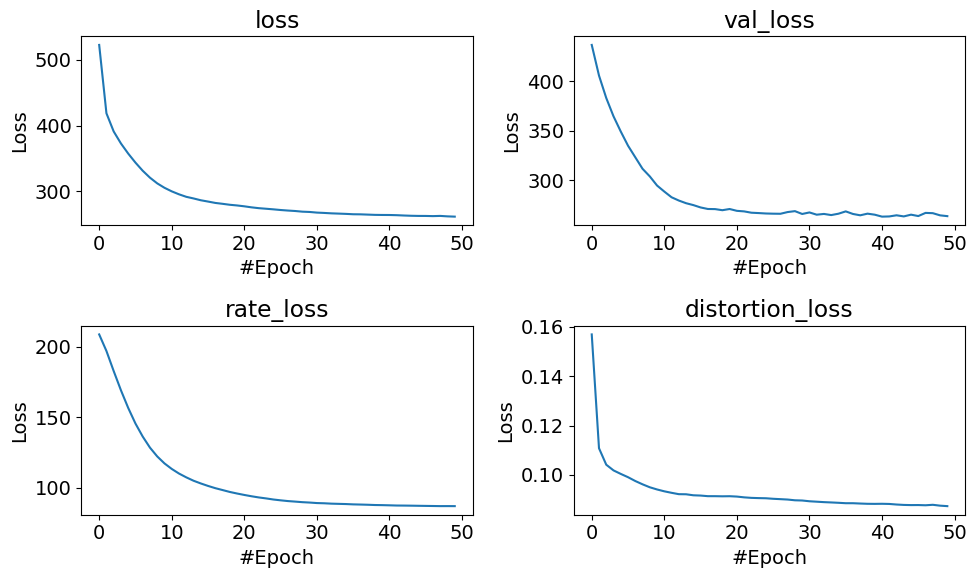

In [13]:
#history.history.keys()
loss_list = ['loss', 'val_loss', 'rate_loss', 'distortion_loss']

# Plot the rate_loss curve.
plt.figure(figsize=(10,6))
for i, l in enumerate(loss_list):
  plt.subplot(2, 2, i + 1)
  plt.plot(history.history[l])
  plt.xlabel('#Epoch')
  plt.ylabel('Loss')
  plt.title(l)

plt.tight_layout()
# plt.savefig('Loss.png', dpi=300, pad_inches=0.1)
plt.show()

## Save Results

In [14]:
# Make a new fodler
path = f"../results/model_patch{patch_size}_lmbda{lmbda}_latent{latent_dims}_learning_rate{learning_rate}_epochs{epochs}_noise{add_noise}"
if not os.path.exists(path):
    os.mkdir(path)

# Save the model
trainer.save_weights(os.path.join(path, 'model'))

# Save loss curve
for l in (loss_list):
    np.savetxt(os.path.join(path, l), history.history[l])

In [15]:
# set the model without training
trainer_for_test, _ = train_das_model(
                    train_dataset,                         # training dataset
                    dev_dataset,                           # dev dataset
                    lmbda=lmbda,                           # weight for rate–distortion Lagrangian
                    latent_dims=latent_dims,               # layers in latent space
                    patch_size = patch_size,               # patch size of the image, must be dividable by 4
                    epochs=epochs,                         # epoch
                    batch_size=batch_size,                 # batch size
                    learning_rate=learning_rate,           # learning rate
                    validation_freq=validation_freq,       # validation frequency
                    launch_trainer = False)                # launch the trainer


# load the pretrained model
trainer_for_test.load_weights(os.path.join(path, 'model'))

# Setup the trained model 
compressor, decompressor = make_das_codec(trainer_for_test)


## Test the reconstruction for whole DAS section

In [21]:
# Load the one of the test data
test_idx = 1
pdata = np.load(file_train[test_idx])['pdata']
patches_original, _, factors = extract_image_patches(pdata, patch_size, add_noise=False)
patches_original = tf.convert_to_tensor(patches_original, dtype=tf.float32)

In [22]:
# Compress them to strings, and keep track of each of their information content in bits.
strings, entropies = compressor(patches_original)

# Decompress the images back from the strings.
patches_decompre = decompressor(strings)

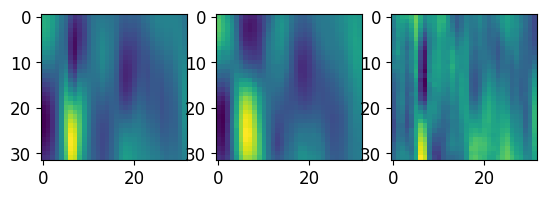

In [23]:
idx = 200
plt.subplot(1,3,1)
plt.imshow(patches_original[idx])
plt.subplot(1,3,2)
plt.imshow(patches_decompre[idx])
plt.subplot(1,3,3)
plt.imshow(patches_original[idx] - patches_decompre[idx])

In [24]:
# Load the original data just from one file
original_shape = pdata.shape
print('shape of original data: ', original_shape)

original_das = reconstruct_image_from_patches(patches_original, factors, original_shape, patch_size)
decompre_das = reconstruct_image_from_patches(patches_decompre, factors, original_shape, patch_size)

shape of original data:  (3100, 3000)


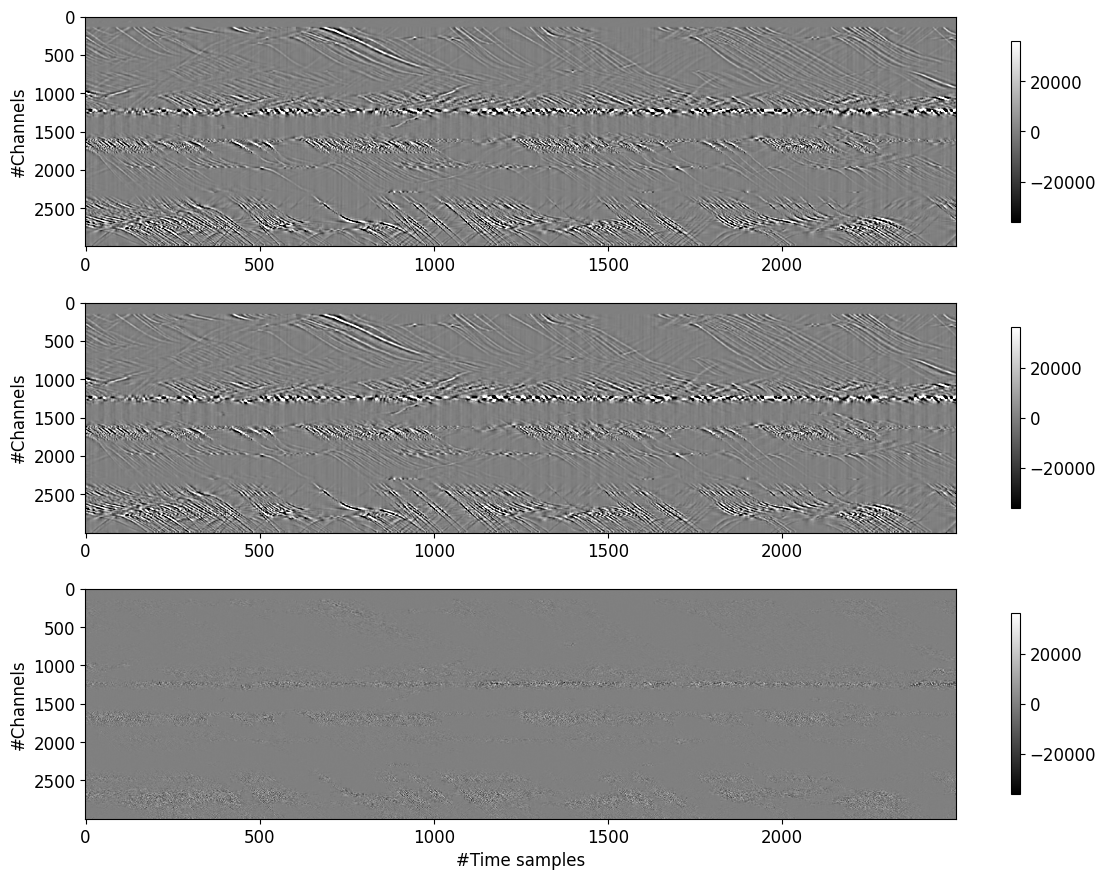

In [25]:
plt.figure(figsize=(12, 9))
plt.rcParams.update({'font.size': 12})
from mpl_toolkits.axes_grid1 import make_axes_locatable

nt = 2500
nc = 3000
aspect = 0.22

relloss = np.sum(np.abs(original_das - decompre_das))/np.sum(np.abs(original_das))
print
plt.subplot(311)
pclip = np.percentile(original_das, 99.)
plt.imshow(original_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
# plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Original DAS')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.subplot(312)
plt.imshow(decompre_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
# plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Reconstructed DAS')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.subplot(313)
plt.imshow(original_das[:nc, :nt] - decompre_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Difference')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.tight_layout()

plt.savefig(os.path.join(path, 'test-DAS.png'), dpi=300, pad_inches=0.1)

In [ ]:
plt.figure(figsize=(12, 9))
plt.rcParams.update({'font.size': 12})
from mpl_toolkits.axes_grid1 import make_axes_locatable

#nt = 2500
nc = 3000
#s_nc = 3000
s_nc = 0
s_nt = 0
nt = 900
#nc = 4800
#aspect = 0.22
aspect = 'auto'

relloss = np.sum(np.abs(original_das - decompre_das))/np.sum(np.abs(original_das))
print
plt.subplot(311)
#pclip = np.percentile(original_das, 99.)
orig_plt = original_das[s_nc:nc, s_nt:nt] #TAC. TURKEYRACOON -> notice all my changes to the plots. something is wrong though.
orig_max = np.abs(orig_plt).max()
vclip = 0.9
pclip = (1.-vclip)*orig_max
#for ic in range(nc): #TAC
  #orig_plt[ic,:] = orig_plt[ic,:]/np.sum(np.abs(orig_plt[ic,:])) #TAC
plt.imshow(orig_plt, cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip) #TAC
#plt.imshow(original_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
# plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Original DAS')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.subplot(312)
decom_plt = decompre_das[s_nc:nc, s_nt:nt] #TAC
decom_max = np.abs(decom_plt).max()
#vclip = 0.8
#pclip = (1.-vclip)*
pclip = .1*pclip*(orig_max/decom_max)
#for ic in range(nc): #TAC
  #decom_plt[ic,:] = decom_plt[ic,:]/np.sum(np.abs(decom_plt[ic,:])) #TAC
plt.imshow(decom_plt, cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip) #TAC
#plt.imshow(decompre_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
# plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Reconstructed DAS')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.subplot(313)
diff_plt = orig_plt - decom_plt #TAC
plt.imshow(diff_plt, cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip) #TAC
#plt.imshow(original_das[:nc, :nt] - decompre_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Difference')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.tight_layout()
#plt.savefig('./drive/MyDrive/DeepLearning/Final-DAS.png', dpi=300, pad_inches=0.1)
# plt.savefig('./drive/MyDrive/SMCityData/Final-DAS.png', dpi=300, pad_inches=0.1) #TAC

In [17]:
# Save the compressed data for stand-alone test
np.save(os.path.join(path, 'original_das'), original_das)
np.save(os.path.join(path, 'decompre_das'), decompre_das)
np.save(os.path.join(path, 'strings.npy'), strings.numpy())
np.save(os.path.join(path, 'entropies.npy'), entropies.numpy())
np.save(os.path.join(path, 'patches_original.npy'), patches_original.numpy())
np.save(os.path.join(path, 'factors.npy'), factors)

In [18]:
# # show the analysis_transform model
# trainer.analysis_transform.summary()

# # show the model
# trainer.synthesis_transform.summary()

# # save figures
# tf.keras.utils.plot_model(trainer.analysis_transform, to_file='model_analysis_transform.png', show_shapes=True, show_dtype=True)
# tf.keras.utils.plot_model(trainer.synthesis_transform, to_file='model_synthesis_transform.png', show_shapes=True, show_dtype=True)